## Classical

In [3]:
import numpy as np
from numpy.polynomial import Polynomial

In [4]:
# Search for key in text
# Key of length 4 and text of length 10 yields nice powers of 2 later
key = "ATCT"
# key_1 = "TGAT"
text = "GTAT_GATC_TC"

text = text.replace("_", "")
m = len(key)
n = len(text)

# Map alphabet to polynomial coefficients
mapping = {
    "A": -3,
    "C": 5,
    "G": -7,
    "T": 11
}

In [5]:
key_enc = np.array([mapping[c] for c in key] + ([0] * (2 * (n - m))))
# key_1_enc = np.array([mapping[c] for c in key_1] + ([0] * (2 * (n - m))))

# key_enc = key_enc + key_1_enc

text_enc = np.array(([0] * (n - m)) + [mapping[c] for c in text[::-1] if c != "_"])

l = (2 * n) - m
assert len(key_enc) == len(text_enc) == l
(key_enc, text_enc)

(array([-3, 11,  5, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([ 0,  0,  0,  0,  0,  0,  5, 11,  5, 11, -3, -7, 11, -3, 11, -7]))

In [6]:
key_freq = np.fft.fft(key_enc)
text_freq = np.fft.fft(text_enc)

tmp = [key_freq[i] * text_freq[i] for i in range(l)]

def cleanup(signal, precision=4):
  return np.round(signal, precision)

res = cleanup(np.fft.ifft(tmp))
res

array([-55.+0.j,  86.+0.j, -77.+0.j,   0.+0.j,   0.+0.j,  -0.+0.j,
       -15.+0.j,  22.+0.j, 131.+0.j, 132.+0.j, 276.+0.j,  98.+0.j,
        -4.+0.j,  62.+0.j, -88.+0.j, 248.+0.j])

In [7]:
# Key fingerprint
fingerprint = np.sum(np.square(key_enc))
fingerprint

276

In [74]:
# Found match at degree
deg = np.argwhere(res == fingerprint)
l - deg - 1

array([[5]])

In [75]:
# Should find at this position
text.find(key)

5

## Quantum

In [103]:
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler, Estimator
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler


In [132]:
key_norm = np.linalg.norm(key_enc)
text_norm = np.linalg.norm(text_enc)

(key_norm, text_norm)

(16.61324772583615, 24.535688292770594)

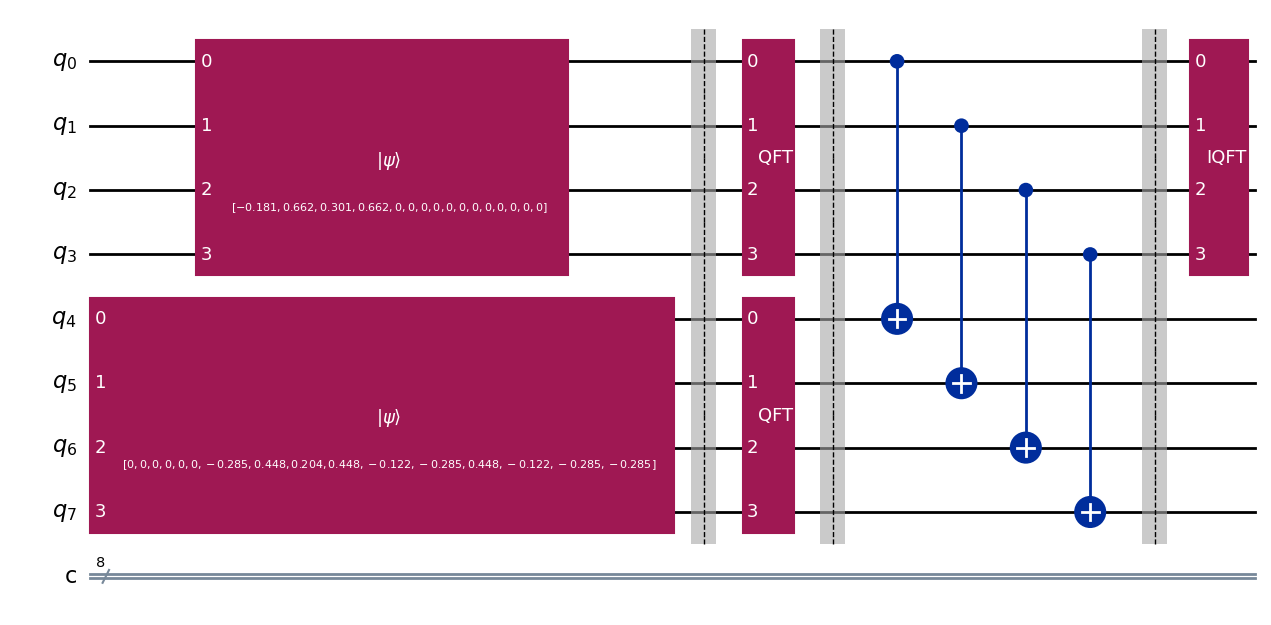

In [135]:
qubits = math.ceil(math.log2(l))
qc = QuantumCircuit(2 * qubits, 2 * qubits)

# Initialize with polynomial encoding
qc.initialize(key_enc / key_norm, range(qubits))
qc.initialize(text_enc / text_norm, range(qubits, 2 * qubits))
qc.barrier()

# Apply QFT
key_qft = QFT(qubits)
text_qft = QFT(qubits)

qc.append(key_qft, range(qubits))
qc.append(text_qft, range(qubits, 2 * qubits))
qc.barrier()

# Elementwise amplitude multiplication
for i in range(qubits):
    qc.cx(i, i + qubits)

# qc.measure(range(qubits, 2 * qubits), range(qubits, 2 * qubits))
qc.barrier()

# Inverse QFT
iqft = QFT(qubits, inverse=True)
qc.append(iqft, range(qubits))

# qc.measure(range(qubits), range(qubits))

qc.draw('mpl', fold=30)

In [154]:
output_state = Statevector(qc).data

conditioned_states = output_state[:2 ** qubits]

norm = np.sqrt(sum(abs(amp)**2 for amp in conditioned_states))
norm_conditioned_states = [amp/norm for amp in conditioned_states]
probabilities = np.abs(norm_conditioned_states) ** 2
probabilities

array([1.39816194e-01, 8.34175666e-02, 3.94278342e-02, 7.45861431e-34,
       1.13344459e-34, 2.43831197e-33, 2.93264883e-03, 8.04649678e-02,
       3.35226366e-02, 2.30495902e-33, 5.06570197e-01, 6.38665745e-02,
       1.06399957e-04, 2.55625898e-02, 7.68739693e-03, 1.66249934e-02])

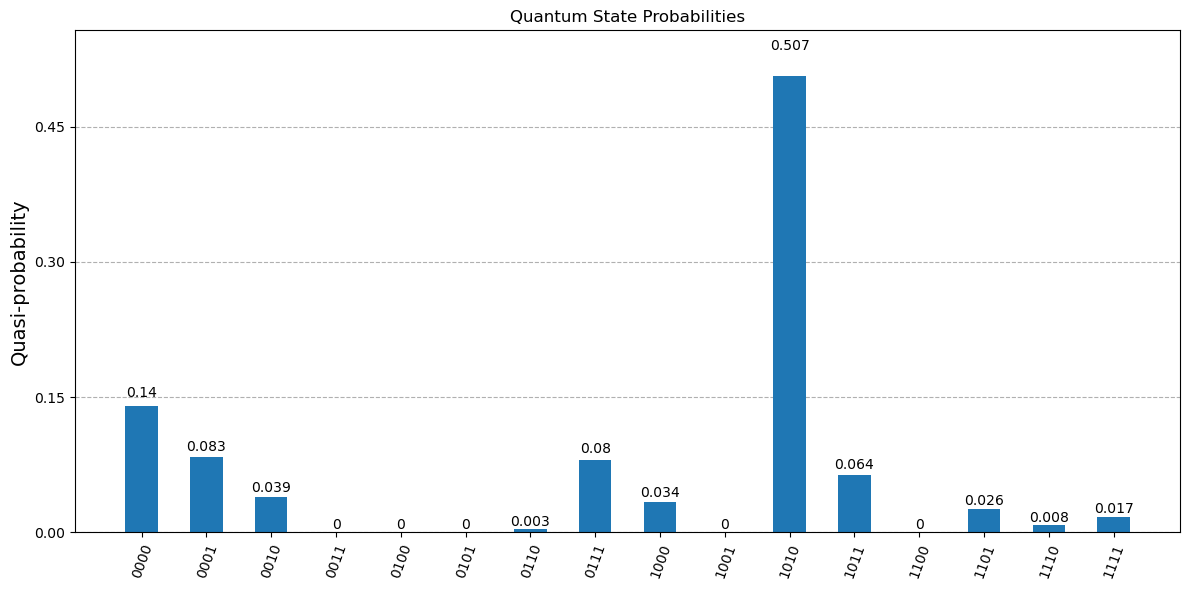

In [155]:
state_labels = [format(i, f'0{qubits}b') for i in range(2 ** qubits)]

# Create a dictionary mapping state labels to their probabilities
# This is the format expected by plot_histogram
counts_dict = {state_labels[i]: probabilities[i] for i in range(2 ** qubits)}

# Plot the histogram
fig, ax = plt.subplots(figsize=(12, 6))
plot_histogram(counts_dict, ax=ax, title='Quantum State Probabilities')
plt.xticks(rotation=70)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

In [158]:
(res / np.linalg.norm(res)) ** 2

array([1.39816194e-01-0.j, 8.34175666e-02-0.j, 3.94278342e-02-0.j,
       0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
       2.93264883e-03+0.j, 8.04649678e-02-0.j, 3.35226366e-02+0.j,
       0.00000000e+00+0.j, 5.06570197e-01+0.j, 6.38665745e-02+0.j,
       1.06399957e-04-0.j, 2.55625898e-02+0.j, 7.68739693e-03-0.j,
       1.66249934e-02+0.j])

In [159]:
res

array([-145.+0.j, -112.+0.j,  -77.+0.j,    0.+0.j,    0.+0.j,    0.+0.j,
         21.+0.j, -110.+0.j,   71.+0.j,   -0.+0.j,  276.+0.j,   98.+0.j,
         -4.+0.j,   62.+0.j,  -34.+0.j,   50.+0.j])

In [ ]:

sampler = AerSampler()
job_sim = sampler.run([qc] , shots=8192)

# Filter distribution where elementwise multiplication succeeded
dist = job_sim.result().quasi_dists[0]
pred = lambda x: x % (2 ** qubits) == 0
dist = {k >> qubits : v for k, v in dist.items() if pred(k)}

dist

plot_histogram(dist)

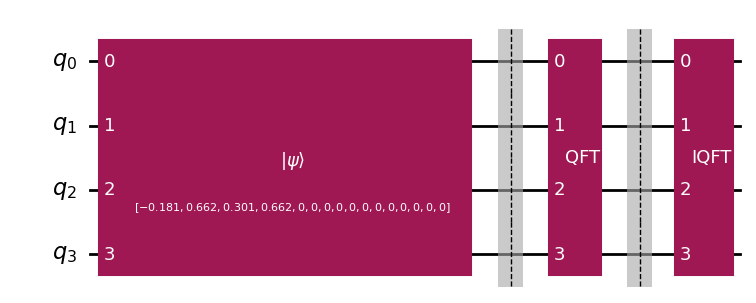

In [130]:
qubits = 4
qc = QuantumCircuit(qubits)

# Initialize with polynomial encoding
qc.initialize(key_enc / np.linalg.norm(key_enc), range(qubits))
# qc.initialize(text_enc / np.linalg.norm(text_enc), range(qubits, 2 * qubits))
qc.barrier()

# Apply QFT
key_qft = QFT(qubits)
# text_qft = QFT(qubits)

qc.append(key_qft, range(qubits))
# qc.append(key_qft, range(qubits, 2 * qubits))
qc.barrier()

# Elementwise amplitude multiplication
# for i in range(qubits):
#     qc.cx(i, i + qubits)

# qc.measure(range(qubits, 2 * qubits), range(qubits, 2 * qubits))
# qc.barrier()

# Inverse QFT
iqft = QFT(qubits, inverse=True)
qc.append(iqft, range(qubits))

# qc.measure(range(qubits), range(qubits))

qc.draw('mpl', fold=30)

In [131]:
conditioned_states = Statevector(qc).data

# conditioned_states = []
# for i in range(2**qubits):  # Loop through all possible states of the first register
#     index = i * (2**qubits)  # This gives indices where the second register is all zeros
#     conditioned_states.append(output_state[index])

# conditioned_states

# conditioned_states = [x for i, x in enumerate(output_state) if i % (2 ** qubits) == 0]
norm = np.sqrt(sum(abs(amp)**2 for amp in conditioned_states))
norm_conditioned_states = [amp/norm for amp in conditioned_states]
norm_conditioned_states

[(-0.18057877962865382+3.68842432033195e-18j),
 (0.6621221919717307-5.707436863899834e-17j),
 (0.30096463271442303+1.1084967741850701e-17j),
 (0.6621221919717306+1.4080092152122085e-17j),
 (5.793121044504864e-18+6.903031024600389e-18j),
 (4.118173737363663e-18-1.97366730398651e-17j),
 (1.4200041269252422e-17-6.160648329533331e-18j),
 (6.486839925574301e-18+2.5083295800377683e-17j),
 (-3.90389457199276e-18-3.3145438399583316e-17j),
 (4.3657223683835054e-17+6.068256576228487e-17j),
 (-3.5560957861135677e-20+1.1084967741850701e-17j),
 (-5.1106239014517226e-17-2.5172219314972322e-17j),
 (9.857830985545728e-18+2.255398305465098e-17j),
 (-5.336337274268123e-18+2.3344870163151632e-17j),
 (-1.523919233106838e-17-1.600928715416807e-17j),
 (4.78061477687791e-17-2.1207562884100512e-17j)]

In [134]:
norm

0.9999999999999992

In [141]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

# Define our input states coefficients in arrays
# For |ψ_in^(1)⟩ = α_00|00⟩ + α_01|01⟩ + α_10|10⟩ + α_11|11⟩
alpha = np.array([0.3, 0.4, 0.5, 0.6])  # [α_00, α_01, α_10, α_11]

# For |ψ_in^(2)⟩ = β_00|00⟩ + β_01|01⟩ + β_10|10⟩ + β_11|11⟩
beta = np.array([0.2, 0.3, 0.7, 0.4])   # [β_00, β_01, β_10, β_11]

# Normalize both input states
alpha = alpha / np.linalg.norm(alpha)
beta = beta / np.linalg.norm(beta)

print(f"Normalized α coefficients: {alpha}")
print(f"Normalized β coefficients: {beta}")

# Calculate the expected element-wise multiplication
expected = alpha * beta

# Normalize the expected output
expected = expected / np.linalg.norm(expected)

print(f"Expected normalized output coefficients: {expected}")

Normalized α coefficients: [0.32349832 0.43133109 0.53916387 0.64699664]
Normalized β coefficients: [0.22645541 0.33968311 0.79259392 0.45291081]
Expected normalized output coefficients: [0.13480593 0.26961187 0.78636795 0.53922374]


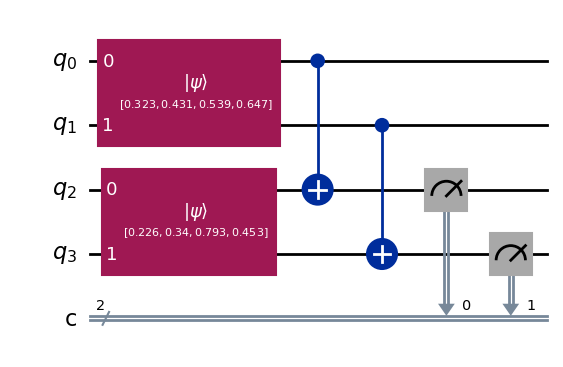

In [142]:
qr = QuantumRegister(4, 'q')  # q[0], q[1] for first register, q[2], q[3] for second register
cr = ClassicalRegister(2, 'c')  # 2 classical bits to measure the second register
circuit = QuantumCircuit(qr, cr)

# Initialize the first register to |ψ_in^(1)⟩
circuit.initialize(alpha, [qr[0], qr[1]])

# Initialize the second register to |ψ_in^(2)⟩
circuit.initialize(beta, [qr[2], qr[3]])

# Apply CNOT gates between corresponding qubits as shown in the figure
# This implements the element-wise multiplication
circuit.cx(qr[0], qr[2])  # CNOT from q[0] to q[2]
circuit.cx(qr[1], qr[3])  # CNOT from q[1] to q[3]

# Measure the second register (qubits 2 and 3)
circuit.measure([qr[2], qr[3]], [cr[0], cr[1]])
circuit.draw('mpl')

In [143]:
circuit_no_measure = circuit.copy()
circuit_no_measure.remove_final_measurements()

In [146]:
statevector = Statevector(circuit_no_measure).data
statevector

array([0.07325794+0.j, 0.14651589+0.j, 0.427338  +0.j, 0.29303177+0.j,
       0.10988692+0.j, 0.09767726+0.j, 0.24419315+0.j, 0.51280561+0.j,
       0.2564028 +0.j, 0.19535452+0.j, 0.12209657+0.j, 0.21977383+0.j,
       0.14651589+0.j, 0.3418704 +0.j, 0.18314486+0.j, 0.14651589+0.j])

In [150]:
filtered = statevector[0:4]
filtered / np.linalg.norm(filtered)

array([0.13480593+0.j, 0.26961187+0.j, 0.78636795+0.j, 0.53922374+0.j])

In [147]:
expected

array([0.13480593, 0.26961187, 0.78636795, 0.53922374])

In [ ]:
# take the first 4